In [142]:
!pip install requests matplotlib geopandas seaborn pandas networkx folium plotly

import requests
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import folium
import geopandas as gpd
import webbrowser

import plotly.graph_objs as go
import json 


In [143]:
# Dictionary to store responses
responses = {}

In [149]:
import os
import pg8000
from dotenv import load_dotenv
from opencage.geocoder import OpenCageGeocode

load_dotenv()

api_key = os.getenv("API_TOKEN")
opencage_key =  os.getenv("OPENCAGE_API_KEY")

def call_api(search_term):
    url = 'https://insights.sdg-innovation-commons.org/semantic/search?page=1&page_limit=100&search=' + search_term
    headers = {'accept': '*/*', 'apikey': apikey } 
    response = requests.get(url, headers=headers)
    data = response.json()
    if data['status'] == 'ok':
        # Add search term as tag to each result individually
        for result in data['hits']:
            result['tags'] = [search_term]  # Each element gets its own tag list containing only the search term
            
            # Check if the URL exists in any existing response
            for existing_term, existing_results in responses.items():
                for existing_result in existing_results:
                    if existing_result['url'] == result['url']:
                        # Add search term to existing element tags
                        if search_term not in existing_result['tags']:
                            existing_result['tags'].append(search_term)
                            # Update current element tags with existing element tags
                            result['tags'] = existing_result['tags']
                            break
    return data

In [150]:
def remove_duplicates(results):
    unique_results = []
    urls_seen = set()
    for result in results:
        url = result['url']
        if url not in urls_seen:
            unique_results.append(result)
            urls_seen.add(url)
    return unique_results

In [151]:
def plot_scores(results):
    scores = [result['score'] for result in results]
    plt.plot(scores)
    plt.xlabel('Result Index')
    plt.ylabel('Score')
    plt.title('Score Distribution')
    plt.show()

In [152]:
search_terms = [
    "Mobile banking",
    "Microfinance",
    "Village Banks",
    "Lending Groups",
    "Saving Groups",
    "Digital Literacy",
    "Digital Inclusion",
    "Financial literacy",
    "Peer-to-peer lending",
    "Financial services",
    "E-commerce",
    "Smart contracts",
    "Remittances",
    "Digital identity",
    "Access to credit",
    "Unbanked",
    "E-wallets",
    "Digital Wallets",
    "Online lending",
    "Financial empowerment",
    "Inclusive banking",
    "Cryptocurrency",
    "Fintech"
]

Fetching results for 'Mobile banking'...


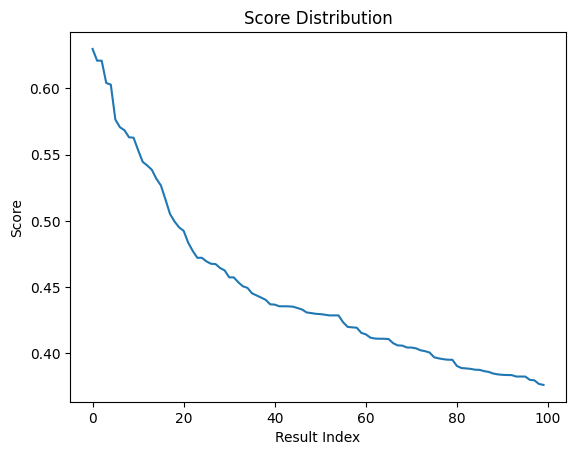

Fetching results for 'Microfinance'...


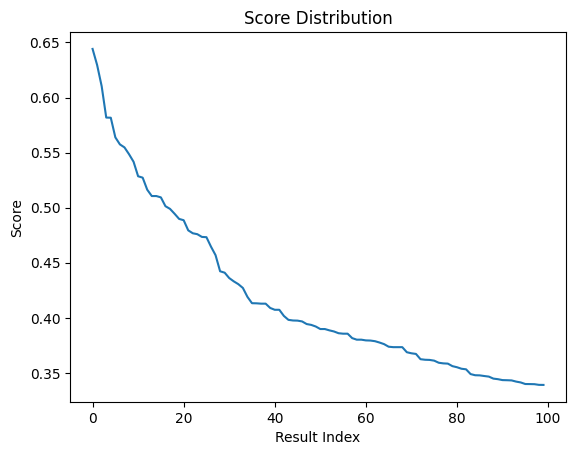

Fetching results for 'Village Banks'...


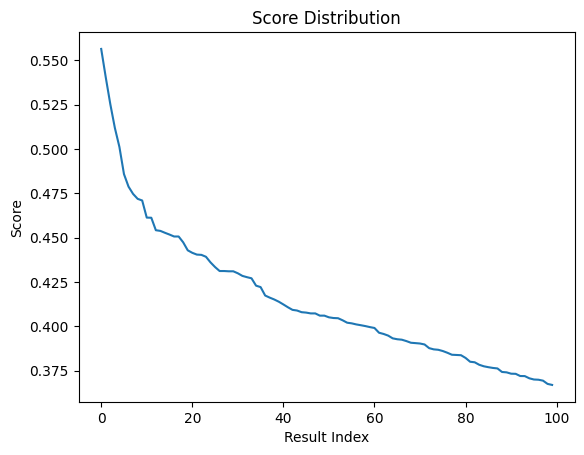

Fetching results for 'Lending Groups'...


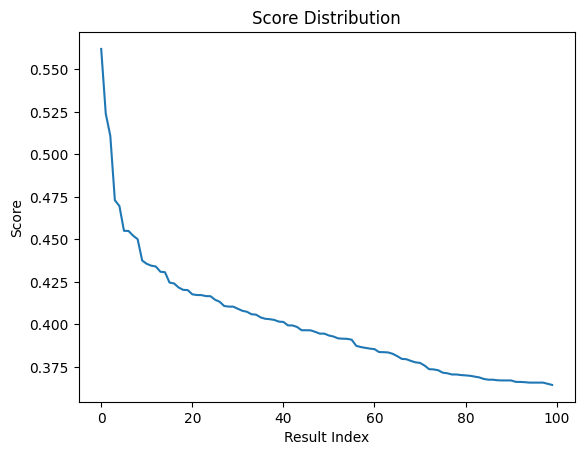

Fetching results for 'Saving Groups'...


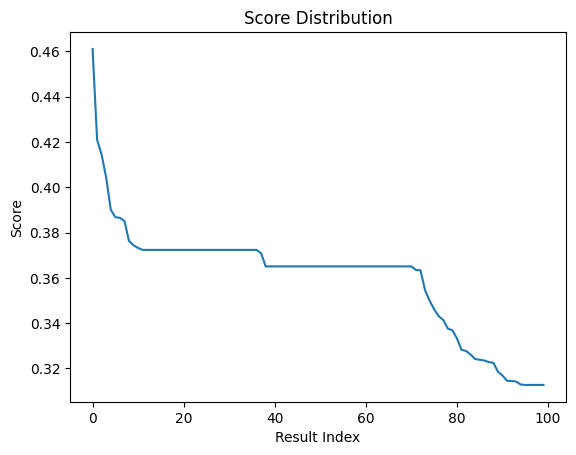

Fetching results for 'Digital Literacy'...


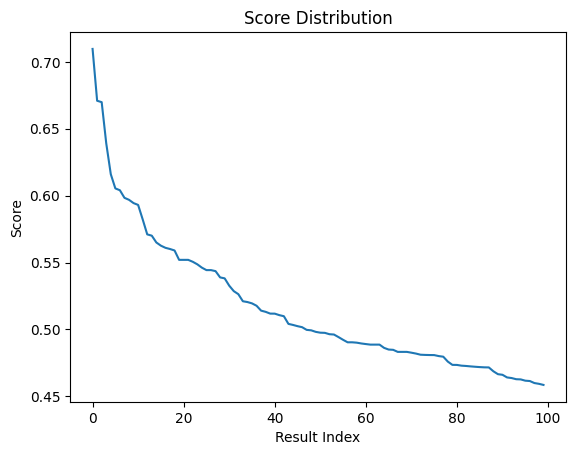

Fetching results for 'Digital Inclusion'...


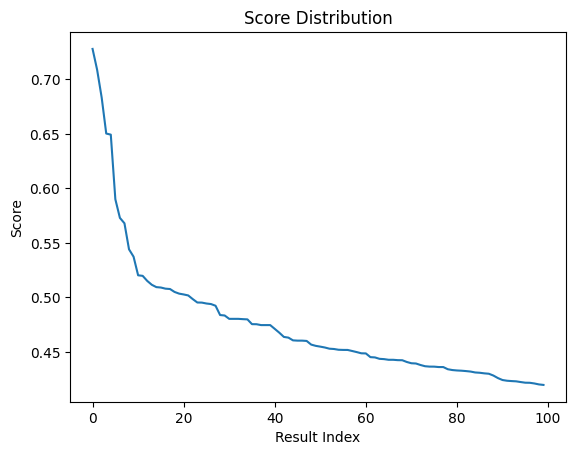

Fetching results for 'Financial literacy'...


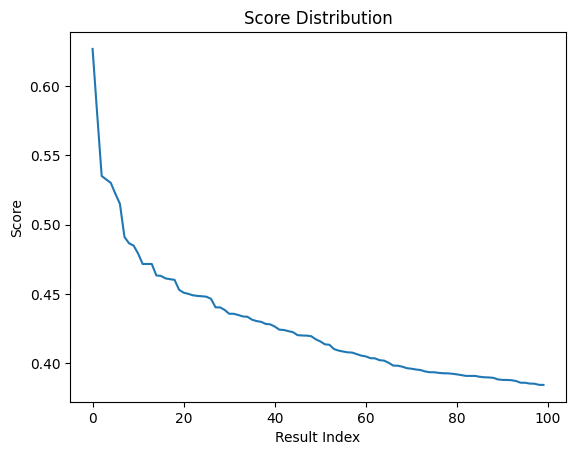

Fetching results for 'Peer-to-peer lending'...


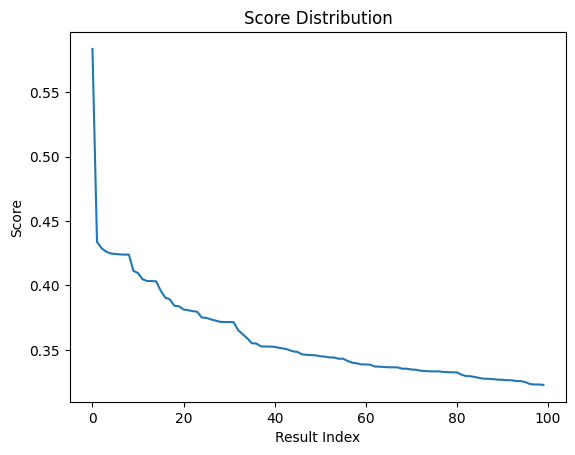

Fetching results for 'Financial services'...


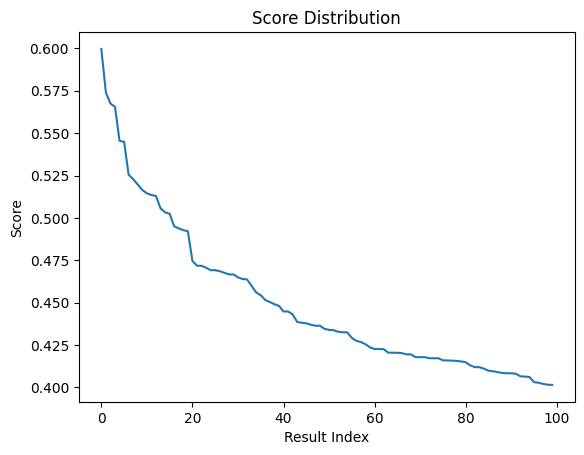

Fetching results for 'E-commerce'...


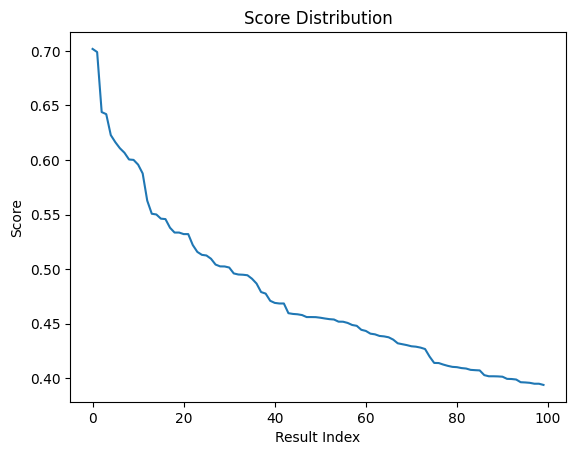

Fetching results for 'Smart contracts'...


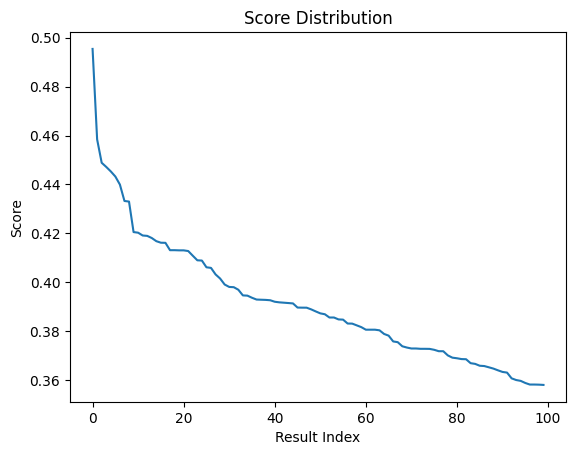

Fetching results for 'Remittances'...


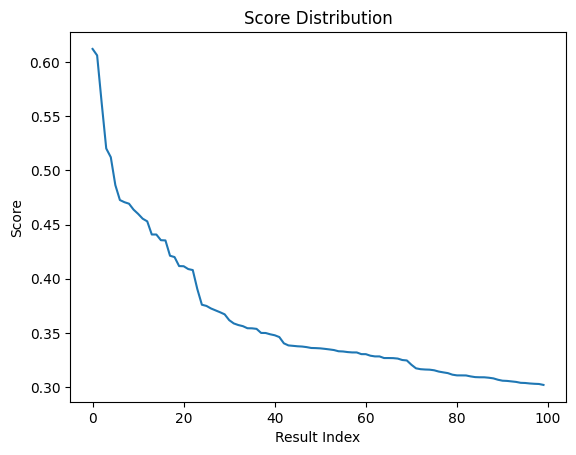

Fetching results for 'Digital identity'...


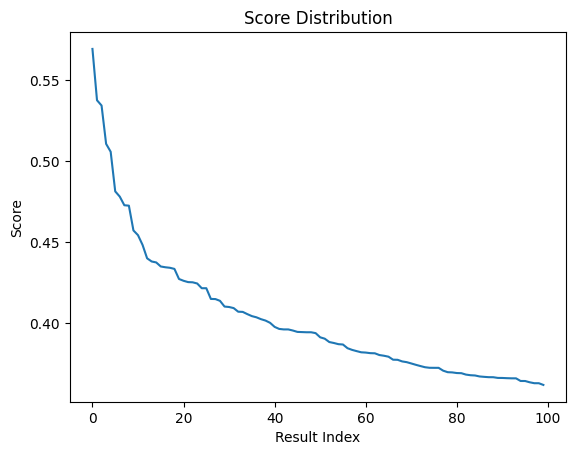

Fetching results for 'Access to credit'...


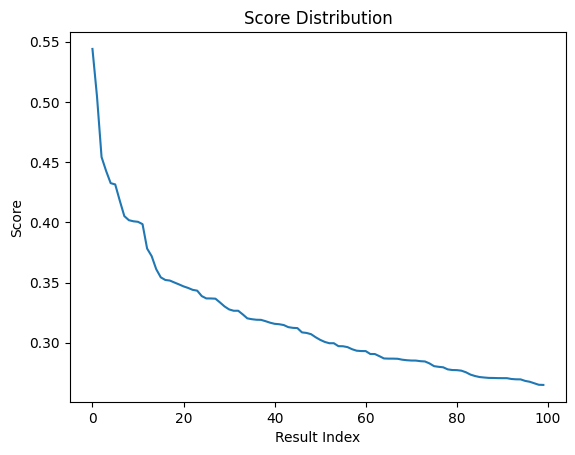

Fetching results for 'Unbanked'...


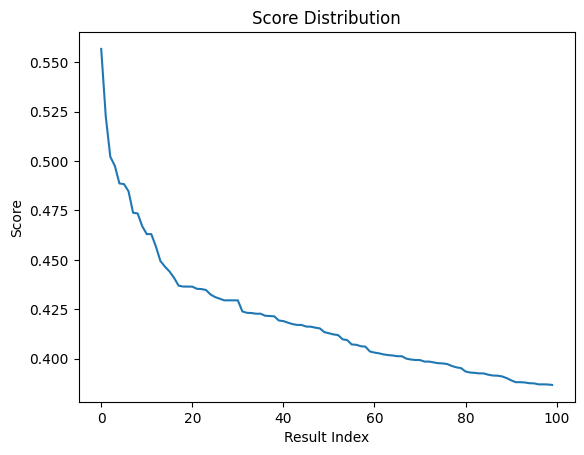

Fetching results for 'E-wallets'...


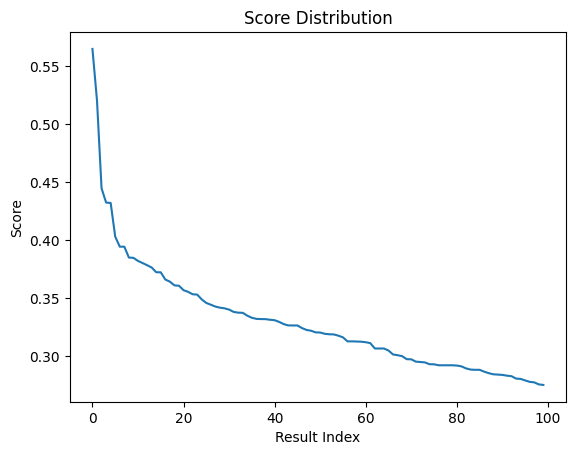

Fetching results for 'Digital Wallets'...


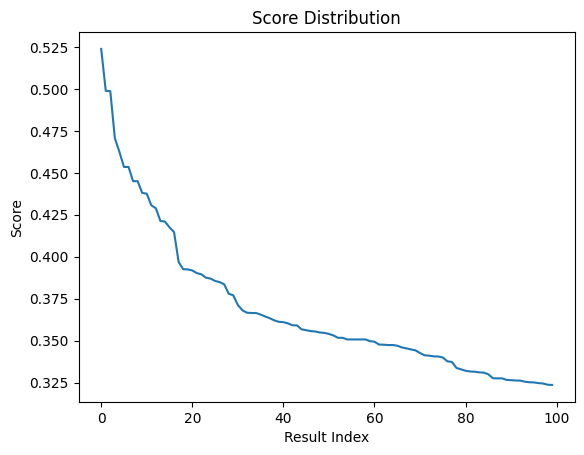

Fetching results for 'Online lending'...


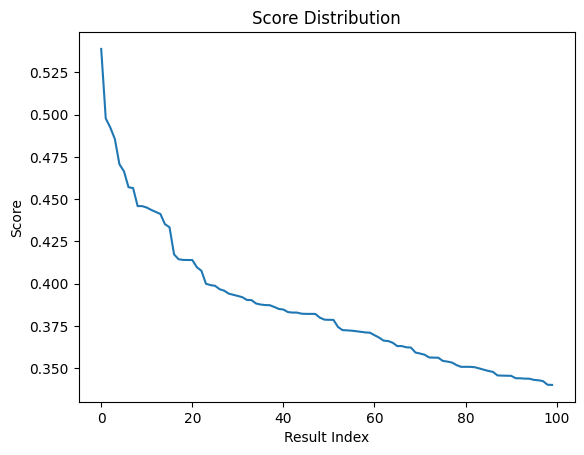

Fetching results for 'Financial empowerment'...


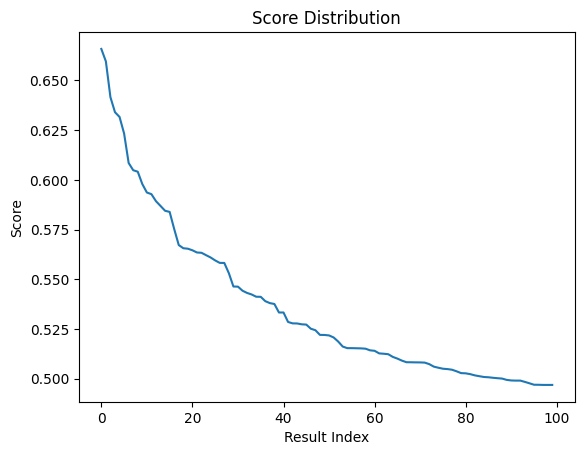

Fetching results for 'Inclusive banking'...


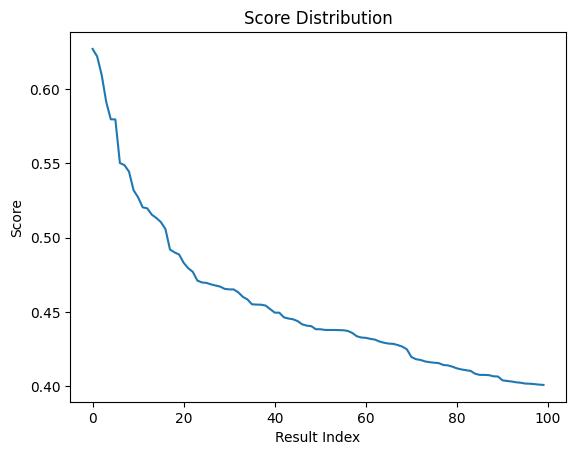

Fetching results for 'Cryptocurrency'...


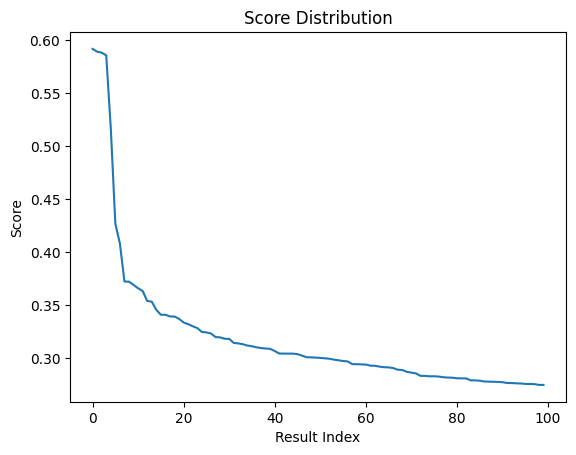

Fetching results for 'Fintech'...


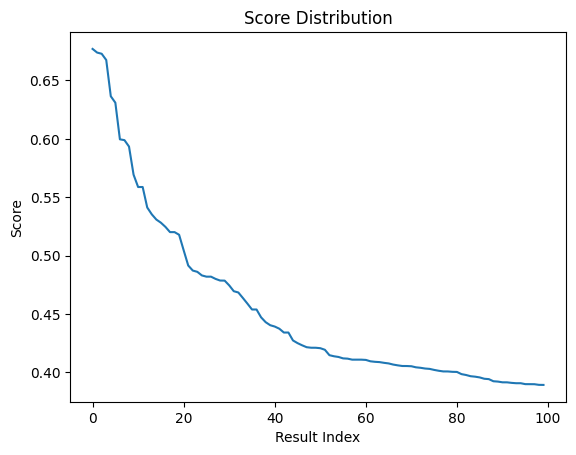

In [153]:
for term in search_terms:
    print(f"Fetching results for '{term}'...")
    response = call_api(term)
    if response['status'] == 'ok':
        results = response['hits']
        unique_results = remove_duplicates(results)
        plot_scores(unique_results)
        responses[term] = unique_results
        time.sleep(60)

In [154]:
def format_date(date_str):
    date_obj = datetime.fromisoformat(date_str)
    formatted_date = date_obj.strftime('%d %B, %Y')
    return formatted_date

In [172]:
def convert_to_markdown(responses):
    # Create the markdown folder if it doesn't exist
    os.makedirs("Search Terms", exist_ok=True)
    
    for index, (term, results) in enumerate(responses.items(), start=1):
        markdown_content = "---\n"
        markdown_content += f"title: {term}\n"
        markdown_content += f"parent_order: 2\n"
        markdown_content += f"nav_order: {index}\n"
        markdown_content += "layout: default\n\n"
        # markdown_content += "tags: " + str([result['tags'] for result in results]) + "\n\n"
        markdown_content += "---\n\n"
        
        for result in results:
            markdown_content += f"## {result['title']}\n\n"
            markdown_content += f"#### Date: {format_date(result['meta']['date'])}\n\n"
            markdown_content += f"#### Country: {', '.join(result['countries'])}\n\n"
            markdown_content += f"#### URL: <a href=\"{result['url']}\" target=\"_blank\">{result['url']}</a>\n\n"
            markdown_content += f"#### Type: {result['meta']['doc_type']}\n\n"
            markdown_content += f"#### Tags: {result['tags']}\n\n"
            markdown_content += f"#### Snippets:\n"
            for snippet in result['snippets']:
                markdown_content += f"- {snippet}\n"
            markdown_content += "<br/><br/><br/>"
            markdown_content += "\n\n\n"
            
        
        file_path = os.path.join("Search Terms", f"{term}.md")
        with open(file_path, "w") as file:
            file.write(markdown_content)


In [173]:
# Call the function to convert responses to markdown files
convert_to_markdown(responses)


In [157]:
# Data Preprocessing
search_terms = list(responses.keys())
tags = set()
for results in responses.values():
    for result in results:
        tags.update(result['tags'])
tags = list(tags)  # Convert tags to a list

In [158]:
# Create Co-occurrence Matrix
co_occurrence_matrix = pd.DataFrame(0, index=search_terms, columns=tags)
for term, results in responses.items():
    for result in results:
        for tag in result['tags']:
            co_occurrence_matrix.at[term, tag] += 1

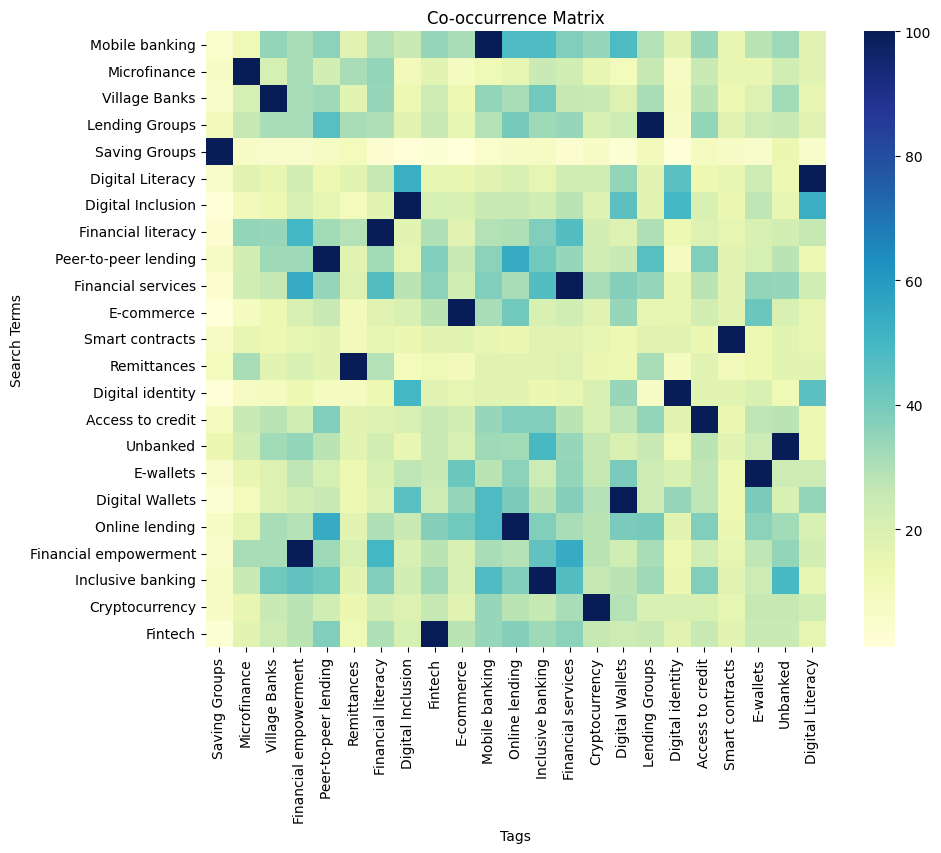

In [159]:
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, cmap="YlGnBu")
plt.title("Co-occurrence Matrix")
plt.xlabel("Tags")
plt.ylabel("Search Terms")
plt.show()

In [160]:
# Create Network Graph
G = nx.Graph()
for term, results in responses.items():
    for result in results:
        for tag in result['tags']:
            G.add_edge(term, tag)

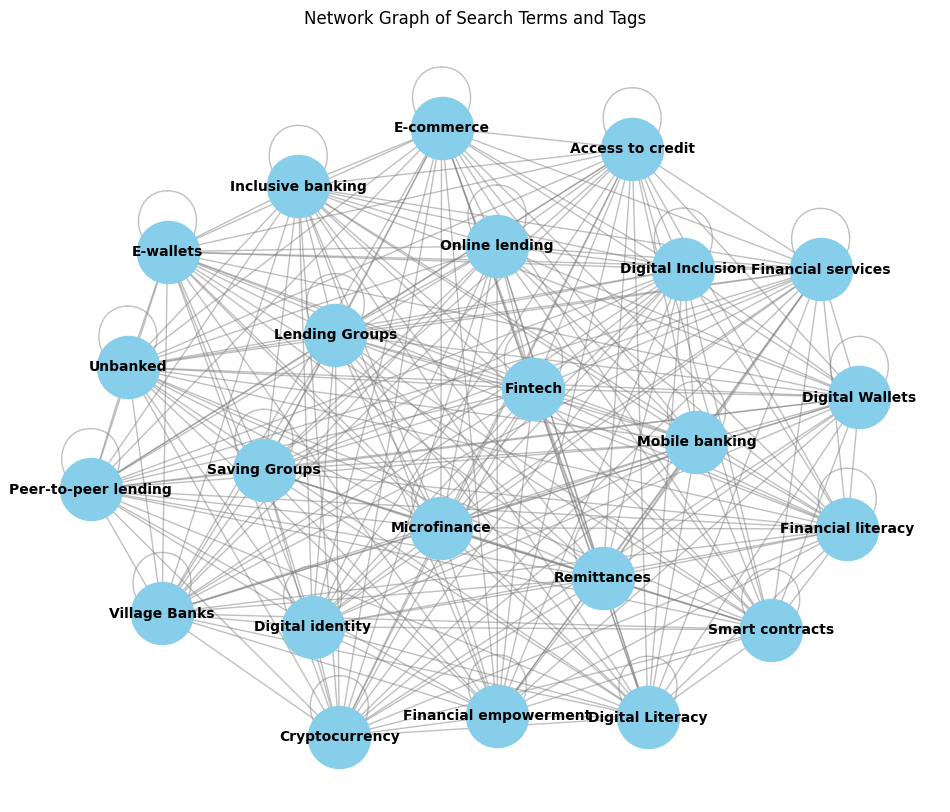

In [161]:
# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)  # Define node positions using spring layout
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Network Graph of Search Terms and Tags")
plt.axis("off")
plt.show()

In [162]:
!pip install opencage


In [163]:
def get_coordinates(country_name):
    try:
        geocoder = OpenCageGeocode(opencage_key)
        results = geocoder.geocode(country_name)
        if results and len(results):
            latitude = results[0]['geometry']['lat']
            longitude = results[0]['geometry']['lng']
            return latitude, longitude, country_name
        else:
            print(f"No coordinates found for country {country_name}")
            return None, None, None
    except Exception as e:
        print(f"Error occurred while fetching coordinates for country {country_name}: {e}")
        return None, None, None


In [184]:
import json
import os

# Specify the path to the JSON file
json_file_path = 'coordinates.json'

from folium.plugins import Fullscreen

# Create a base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Initialize Fullscreen control
Fullscreen().add_to(m)

# Check if the JSON file exists
if os.path.exists(json_file_path):
    # Read the coordinates from the JSON file
    with open(json_file_path, 'r') as json_file:
        coord = json.load(json_file)
else:
    coord = {}  # Create an empty dictionary if the file doesn't exist

# Initialize a dictionary to store unique titles and URLs for each country
country_titles = {country: set() for country in coord.keys()}

# Iterate over responses and add titles and URLs to the country_titles dictionary
for term, results in responses.items():
    for result in results:
        countries = result.get('countries', [])
        title = result['title']
        url = result['url']
        for country in countries:
            # Check if the URL is already in the set for this country
            if url not in country_titles[country]:
                country_titles[country].add((title, url))

# Iterate over country_titles and create markers for each location
for country, titles in country_titles.items():
    if country in coord and coord[country] is not None:
        latitude, longitude, country_name = coord[country]
    else:
        latitude, longitude, country_name = get_coordinates(country)
        if latitude is not None and longitude is not None and country_name is not None:
            coord[country] = [latitude, longitude, country_name]
            # Update the JSON file with the new entry
            with open(json_file_path, 'w') as json_file:
                json.dump(coord, json_file)

    if latitude is not None and longitude is not None and country_name is not None:
        # Concatenate unique titles and URLs into a single string
        titles_str = '<br>'.join([f'<a href="{url}" target="_blank">{title}</a><br>' for title, url in titles])
        # Add a marker for each location with the concatenated titles as popup
        popup_html = f'<p>{titles_str}</p><p>{country_name}</p>'
        folium.Marker([latitude, longitude], popup=popup_html).add_to(m)

In [185]:
# Create/save the map
m.save('map.html')

In [166]:

# Create Network Graph
G = nx.Graph()
for term, results in responses.items():
    for result in results:
        for tag in result['tags']:
            G.add_edge(term, tag)

# Plot Network Graph
pos = nx.spring_layout(G)
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)  
    edge_trace['y'] += (y0, y1, None)  


# Initialize node_trace 'x' and 'y' as empty lists
node_trace = {
    'x': [],
    'y': [],
    'text': [],
    'mode': 'markers',
    'hoverinfo': 'text',
    'marker': {
        'showscale': True,
        'colorscale': 'YlGnBu',
        'reversescale': True,
        'color': [],
        'size': 10,
        'colorbar': {
            'thickness': 15,
            'title': 'Node Connections',
            'xanchor': 'left',
            'titleside': 'right'
        },
        'line': {'width': 2}
    }
}


# Iterate over nodes and add coordinates to node_trace
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(node)




fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    # title='<br>Network Graph',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# Save Network Graph as HTML file
graph_html = "network_graph.html"
fig.write_html(graph_html, auto_open=True)


In [194]:
import plotly.graph_objs as go

# Create Co-occurrence Matrix
co_occurrence_matrix = pd.DataFrame(0, index=search_terms, columns=tags)
result_titles = {tag: {term: set() for term in search_terms} for tag in tags}  # Store unique result titles and URLs for each tag and search term

for term, results in responses.items():
    for result in results:
        for tag in result['tags']:
            if tag not in co_occurrence_matrix.columns:
                co_occurrence_matrix[tag] = 0
            co_occurrence_matrix.at[term, tag] += 1
            title = result['title']
            url = result['url']
            if (title, url) not in result_titles[tag][term]:  # Check if title-url pair already exists
                result_titles[tag][term].add((title, url))  # Store unique title and URL pair

# Create hover text with clickable titles and include x and y values
hover_text = [
    [f"Titles:<br>{'<br>'.join([f'<a href="{url}" target="_blank">{title}</a>' for title, url in result_titles[tag][term]])}<br>Coordinates: x={tag}, y={term}"
     for tag in co_occurrence_matrix.columns] for term in co_occurrence_matrix.index
]

# Create Heatmap
heatmap = go.Heatmap(
    z=co_occurrence_matrix.values,
    x=co_occurrence_matrix.columns,
    y=co_occurrence_matrix.index,
    colorscale='Viridis',
    hoverinfo='z+text',  # Display both cell value and hover text
    text=hover_text
)

# Layout
layout = go.Layout(
    title='Co-occurrence Matrix',
    xaxis=dict(title='Tags'),
    yaxis=dict(title='Search Terms'),
    clickmode="event+select"
)

# Create Figure
fig = go.Figure(data=[heatmap], layout=layout)

# Save as HTML file
heatmap_html = "co_matrix.html"
fig.write_html(heatmap_html, auto_open=True)


In [195]:
with open('data.json', 'w') as data_file:
                json.dump(responses, data_file)